In [1]:
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask

from core.core_functions import mask_domain
from core.mapplot_functions import plot_map_base


dpi = 300
mpl.rc('font', **{'size': 8})
cm = 1/2.54  # centimeters in inches

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/.conda/envs/lb_python/share/proj failed


In [16]:
path = '/work/uc1275/LukasBrunner/MMLEAv2/rx1day'
savepath = '/work/uc1275/LukasBrunner/data/ETCCDI-MPI/mmlea/rx1day'
fig_path = '../figures'

In [3]:
# some copy-pasted functions from other work just for the colorbar

def get_listed_colormap(levels, cmap='viridis', extend='neither', white=None, return_colors=False):
    """

    Parameters
    ----------
    levels : list
        List of levels giving the bounds of the levels, i.e., the number of colors is len(levels) - 1
    """
    
    if isinstance(levels, (int, np.int64)):
        nr = levels
    else:
        nr = len(levels) - 1

    if white is not None:
        nr -= 1

    if extend == 'both':
        nr += 2
    elif extend == 'max' or extend == 'min':
        nr += 1

    colors = mpl.colormaps[cmap](np.linspace(0, 1, nr))
    if white is not None:
        if white == 'first':
            colors = np.concatenate([[[1, 1, 1, 1]], colors])
        if white == 'last':
            colors = np.concatenate([colors, [[1, 1, 1, 1]]])

    if return_colors:
        return colors

    if extend == 'neither':
        cmap = mpl.colors.ListedColormap(colors)
    elif extend == 'both':
        cmap = mpl.colors.ListedColormap(colors[1:-1])
        cmap.set_under(colors[0])
        cmap.set_over(colors[-1])
    elif extend == 'min':
        cmap = mpl.colors.ListedColormap(colors[1:])
        cmap.set_under(colors[0])
    elif extend == 'max':
        cmap = mpl.colors.ListedColormap(colors[:-1])
        cmap.set_over(colors[-1])
    else:
        raise ValueError

    return cmap


def get_diverging_colormap(levels=12, cmap_neg='Blues', cmap_pos='Reds', middle_white=True, extend='both', return_colors=False):
    if isinstance(levels, int):
        nr = levels
    else:
        nr = len(levels) - 1

    white = None
    if nr % 2 == 0:
        nr //= 2
        if middle_white:
            nr -= 1
            white = [[1, 1, 1, 1], [1, 1, 1, 1]] 
    else:
        if middle_white:
            nr = (nr - 1) // 2
            white = [[1, 1, 1, 1]] 
        else:
            raise ValueError

    if extend == 'both':
        nr += 1
    elif extend != 'neither':
        raise ValueError(f'extend has to be one of "both", "neither" not {extend}')
            
    neg = get_listed_colormap(nr, cmap_neg, return_colors=True)[::-1]
    pos = get_listed_colormap(nr, cmap_pos, return_colors=True)

    if white is None:
        colors = np.concatenate([neg, pos]) 
    else:
        colors = np.concatenate([neg, white, pos]) 
    
    
    if return_colors:
        return colors
    if extend == 'neither':
        cmap = mpl.colors.ListedColormap(colors)
    else:
        cmap = mpl.colors.ListedColormap(colors[1:-1])
        cmap.set_under(colors[0])
        cmap.set_over(colors[-1])
    return cmap

In [4]:
files = glob(os.path.join(path, '*.nc'))

In [5]:
models = set()
paths = {}
for file in glob(os.path.join(path, '*.nc')):
    model = file.split('_')[2]
    forcing = file.split('_')[3]
    if forcing != 'historical':  # for CESM2 this is different
        if forcing in ['cmip6', 'smbb']:
            # we have 'CMIP6' and 'SMBB' for smoothed biomass burning, i.e., slightly different forcing
            model += '_' + forcing
        else:
            continue
    models.add(model)
    try:
        paths[model].append(file)
    except KeyError:
        paths[model] = [file]


In [6]:
models

{'ACCESS-ESM1-5',
 'CESM1-CAM5',
 'CESM2_cmip6',
 'CESM2_smbb',
 'CSIRO-Mk3-6-0',
 'CanESM2',
 'CanESM5',
 'E3SMv2',
 'EC-Earth3',
 'GFDL-CM3',
 'GFDL-SPEAR-MED',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'UKESM1-0-LL'}

In [7]:
# # model = 'ACCESS-ESM1-5'
# ds_all = {}
# for model in models:
#     print(model)
#     ds_list = []
#     for file in paths[model]:
#         try:
#             ds = xr.open_dataset(file, decode_timedelta=False)
#         except Exception:
#             print(file)
#             continue
#         ds = ds.sel(time=slice('1995', '2014')).groupby('time.year').max('time').mean('year')
#         ds_list.append(ds)
#     ds = xr.concat(ds_list, dim='member')
#     ds.to_netcdf(os.path.join(savepath, model + '.nc'))
#     ds_all[model] = ds

In [8]:
ds_all = {}
for model in models:
    ds = xr.open_dataset(os.path.join(savepath, model + '.nc'))
    ds_all[model] = ds

In [9]:
# Rank analysis

tmp = xr.concat([ds.std('member') for ds in ds_all.values()], dim='model', coords='minimal', compat='override')
tmp['model'] = xr.DataArray(list(ds_all.keys()), dims='model')
mpi_rank = tmp.rank('model', pct=True).sel(model='MPI-ESM1-2-LR')['Rx1day'] * 100
mpi_rank = mask_domain(mpi_rank).squeeze()

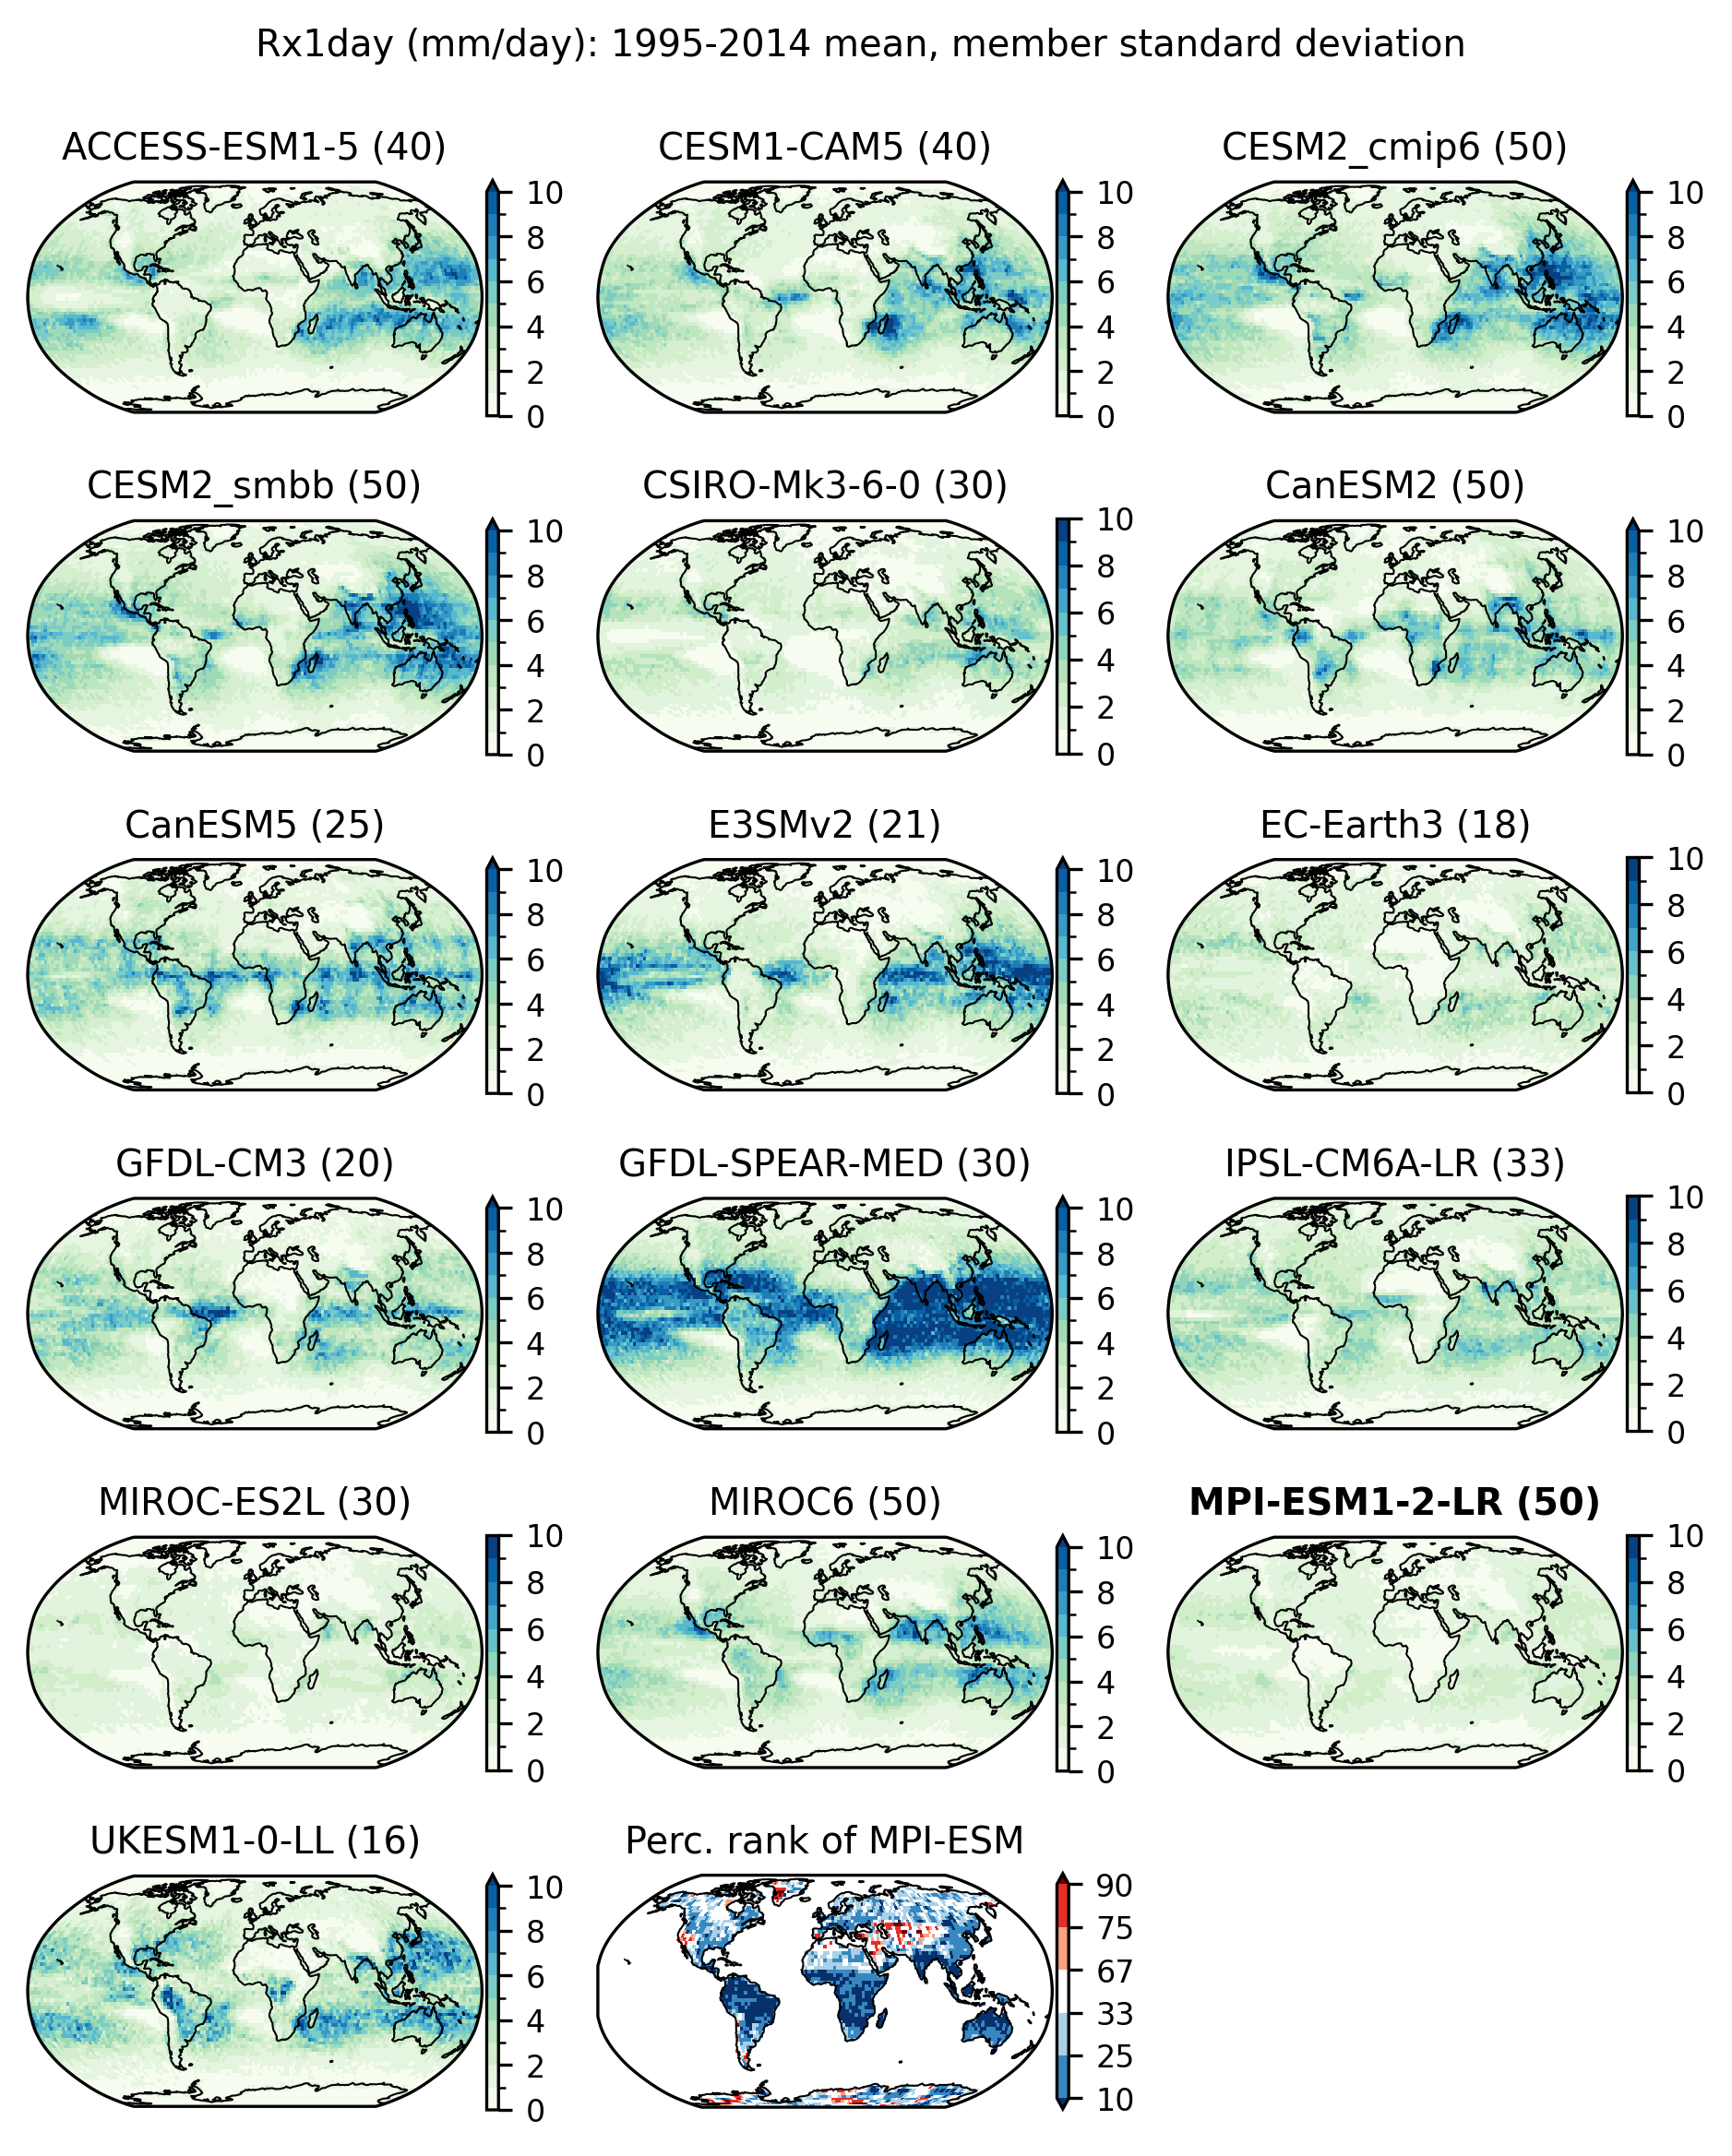

In [17]:
kwargs = dict(
    transform = ccrs.PlateCarree(),
    cbar_kwargs = {'label': '', 'fraction': .025, 'pad': .01},
    cmap = 'GnBu',
    levels = np.arange(0, 11, 1),
)

kwargs_rank = dict(
    transform=ccrs.PlateCarree(),
    cmap = mpl.colors.ListedColormap(
        get_diverging_colormap(9, return_colors=True, extend='neither')[np.array([0, 1, 2, 4, 6, 7, 8])]),
    extend='both',
    levels = np.array([10, 25, 33, 67, 75, 90]),
    cbar_kwargs = {'label': '', 'fraction': .025, 'pad': .01},
)

fig, axes = plt.subplots(6, 3, figsize=(16*cm, 20*cm), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)
for idx, ax in enumerate(axes.ravel()):
    if idx < len(models):
        model = sorted(list(models))[idx]
        da = ds_all[model]['Rx1day'] * 60*60*24  # kg m-2 s-1 to mm/day
        da.std('member').plot.pcolormesh(ax=ax, **kwargs)
        if model == 'MPI-ESM1-2-LR':
            ax.set_title(f'{model} ({da.member.size})', fontweight='bold')
        else:
            ax.set_title(f'{model} ({da.member.size})')
        ax.coastlines(lw=.5)
        
    else:
        break

ax = axes.ravel()[idx]
mpi_rank.plot.pcolormesh(
    ax=ax,        
    **kwargs_rank,
)
ax.coastlines(lw=.5)
ax.set_title('Perc. rank of MPI-ESM') 

axes.ravel()[idx + 1].set_visible(False)
        
fig.suptitle('Rx1day (mm/day): 1995-2014 mean, member standard deviation \n')
fig.tight_layout()

plt.savefig(os.path.join(fig_path, 'rx1day_smile_comparison.png'), dpi=dpi)
plt.savefig(os.path.join(fig_path, 'rx1day_smile_comparison.pdf'), dpi=dpi)